In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

## 3. Логистическая регрессия. Реализация

Функция ошибки для логистической регрессии в случае бинарной классификации называется бинарной кросс-энтропией и записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i))),$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}$$

Реализация логистической регрессии будет основана на оптимизации функции ошибки градиентным спуском.

В качестве экспериментальных данных возьмем датасет о доходах граждан в различных странах [Adult Income](https://archive.ics.uci.edu/ml/datasets/Adult) и сделаем необходимую предобработку.

In [2]:
adult = pd.read_csv('./3.9_adult.data',
                    names=['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])

In [3]:
# Описание датасета

# with open('./data/adult.names', 'r') as f:
#     names = f.read()
# print(names)

In [4]:
adult.head(2)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [5]:
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

In [6]:
adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [7]:
# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

In [8]:
adult.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1.057047,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.775768,1.408176,1.134739,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0


In [9]:
# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [10]:
# Реализовать функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

In [11]:
# Реализовать функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

In [12]:
def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

In [13]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)

In [14]:
theta

array([-3.18220152e+00, -7.85036544e-01,  3.36378365e-01,  1.02420428e+00,
        9.87311090e-01,  1.59897859e-01,  6.08930383e-01,  6.37883564e-01,
        8.11280626e-01,  5.89057982e-01,  3.38583874e-01,  3.24397258e-01,
        2.36520366e-01,  1.14915955e+00, -1.59850366e-02,  1.02543563e+00,
        5.20449527e-01, -1.29220590e-02,  6.93612812e-03,  9.88443132e-04,
        5.34420479e-01,  8.40399041e-01,  6.46143233e-01,  5.53494533e-01,
       -4.28230037e-01, -1.39716497e+00,  7.95663040e-01,  9.48510850e-01,
        8.85025416e-01,  9.33962074e-01, -2.97874470e-01,  7.79500017e-02,
        2.58558666e-01,  4.91984312e-01,  7.61509306e-01,  9.74747564e-01,
        3.30697269e-01,  9.64814314e-01, -7.81877921e-02,  6.90788800e-01,
        6.11752440e-01,  6.22907129e-01,  3.38009780e-01,  5.62066615e-01,
       -6.37888463e-01,  8.35398252e-01,  3.95775461e-01,  9.09710550e-01,
        2.21719660e+00,  9.95948149e-01,  6.21876481e-01,  4.08394474e-01,
        6.18223280e-01,  

In [15]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [16]:
# Сделать предсказания на тренировочной выборке и
# посчитать значение метрики accuracy и F1-score
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)

acc = 0.85 F1-score = 0.65


In [17]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
y_pred = sigmoid(X_valid, theta) > 0.5

print_logisitc_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.65


In [18]:
# Отрисовать ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

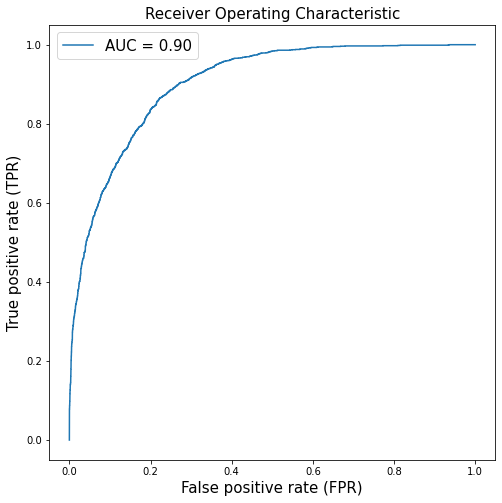

In [19]:
# Вычислить вероятности принадлежности классу 1 для каждого объекта из валидационной выборки
y_pred_proba = sigmoid(X_valid, theta)
calc_and_plot_roc(y_valid, y_pred_proba)

## 4. Добавление регуляризации

### 4.1. Оборачивание линейной регрессии в класс

In [20]:
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    def optimize(self, X, y, start_theta, n_iters):
        theta = start_theta.copy()

        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)

        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

In [21]:
class LinReg(RegOptimizer):
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)

        return grad
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = X.dot(self.theta)
        
        return y_pred

In [22]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')
def prepare_boston_data():
    data = load_boston()
    X, y = data['data'], data['target']
    # Нормализовать даннные с помощью стандартной нормализации
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [23]:
linreg = LinReg(0.01, 500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

/home/dex/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset

In [24]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 22.09, RMSE = 4.70


### 4.2. Оборачивание логистической регрессии в класс

In [25]:
class LogReg(RegOptimizer):
    def sigmoid(self, X, theta):
        return 1. / (1. + np.exp(-X.dot(theta)))
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)

        return grad
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')
        
        y_pred = self.predict_proba(X) > 0.5
        
        return y_pred

In [7]:
def prepare_adult_data():
    adult = pd.read_csv('./3.9_adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    
    # Избавиться от лишних признаков
    adult.drop(['native-country'], axis=1, inplace=True)
    # Сконвертировать целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделать one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
    
    # Нормализовать нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
    
    # Разбить таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавить фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [27]:
logreg = LogReg(1., 300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [28]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

acc = 0.84 F1-score = 0.65


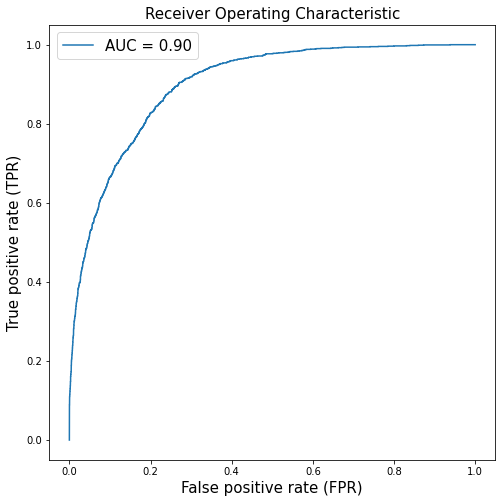

In [29]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

В случаях линейной и логистической регрессии будем добавлять к функции ошибки регуляризующую часть как:
$$\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $\theta$ — вектор параметров линейной модели без фиктивного признака (intercept/bias term), $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации.

### 4.3. Добавление регуляризатора в линейную регрессию

После добавления регуляризации функция ошибки линейной регрессии будет выглядеть следующим образом:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} + \frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2}$$
А ее градиент по параметру $\theta$:
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j} = \frac{1}{n}X^T(X\theta - y) + \frac{\lambda}{m}\sum_{j=1}^{m}{\theta_j}$$

In [30]:
class LinRegRegularized(LinReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LinRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [31]:
linreg = LinRegRegularized(alpha=0.01, lambd=0.05, n_iters=500)
X, y = prepare_boston_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

/home/dex/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset

In [32]:
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)
print_regression_metrics(y_valid, y_pred)

MSE = 26.92, RMSE = 5.19


### 4.4. Добавление регуляризатора в логистическую регрессию

Функция ошибки для логистической регрессии в случае бинарной классификации с регуляризатором записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i)))+\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}+\frac{\lambda}{m}\sum_{j}^{m}{\theta_j}$$

In [33]:
class LogRegRegularized(LogReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LogRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [ ]:
logreg = LogRegRegularized(alpha=1., lambd=1., n_iters=300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибку F1-score

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logisitc_metrics(y_valid, y_pred)

In [ ]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

### TASKS

In [ ]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [ ]:
# Сделать предсказания на тренировочной выборке и
# посчитать значение метрики accuracy и F1-score
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)

#### Задание 3.9.1 
Постройте модель логистической регрессии при помощи sklearn. Используйте параметры по умолчанию, обучите на всей выборке и посчитайте F1 score.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

adult = pd.read_csv('./3.9_adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

############ 3.9.1 
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_valid)

# print_logisitc_metrics(y_valid, y_pred)
f1_score = metrics.f1_score(y_valid, y_pred) 
print(f'f1_score = {f1_score:.2f}')

#### Задание 3.9.7
Провалидируйте логистическую регрессию из sklearn на 5-fold кросс-валидации. В логистической регрессии надо выставить random_state=42. Какой получился средний F1-score?

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def train_validate(X, y):
    # Разбить данные на train/valid
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    # Создать и обучить линейную регрессию    
    logreg = LogisticRegression(max_iter=500)
    logreg.fit(X_train, y_train) 
    
    # Сделать предсказания по валидционной выборке
    y_pred = logreg.predict(X_valid)


    # Посчитать значение ошибок MSE и RMSE для валидационных данных
    print_regression_metrics(y_valid, y_pred)
    
    # F1-score
    f1_score = metrics.f1_score(y_valid, y_pred) 
    print(f'f1_score = {f1_score:.2f}')

In [ ]:
train_validate(X, y)
#f1_score = 0.67 is correct answer

#### Задание 3.9.2 
Посчитайте confusion matrix для классификатора из задачи 3.9.1. Для получения матрицы можно воспользоваться методом sklearn.metrics.confusion_matrix(y_true, y_pred), либо посчитать каждый элемент вручную. 

In [ ]:
#task 3.9.2
#https://www.machinelearningmastery.ru/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a/

############ 3.9.2 (в задании не просили делить датасет на train и test, нужно обучиться и валидироваться на всем датасете)
from sklearn.metrics import confusion_matrix

logreg.fit(X, y) 
y_pred = logreg.predict(X)
confusion_matrix(y, y_pred)

array([[23028,  1692],
       [ 3124,  4717]]) is correct answer

#### Задание 3.9.5
Переберите коэффициенты L2-регуляризации от 0.01 до 1 с шагом 0.01 и определите, на каком из них модель логистической регрессии из sklearn даёт наибольший F1-score.
documentation:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic%20regression#sklearn.linear_model.LogisticRegression

WRONG
WHY?

In [20]:
adult = pd.read_csv('./3.9_adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    
# Избавиться от лишних признаков
adult.drop(['native-country'], axis=1, inplace=True)
# Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])

# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [21]:
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression

In [22]:
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression

c_list = np.arange(0.01, 1.01, 0.01)
max_f1 = -1
max_c = -1
for c in c_list:
    LRC = LogisticRegression(C=c, penalty='l2', random_state=823, max_iter=500)
    LRC.fit(X, y)
    y_pred = LRC.predict(X)
    f1 = metrics.f1_score(y, y_pred)
    if f1 > max_f1:
        max_f1 = f1
        max_c = c

print(max_c) #Должно получаться 0.88.

0.99


In [23]:
#whats below is uncorrect for task
lam_395 = 0.01
how_much_cycle = int(1/lam_395)
F1_score_array = []
###
max_f1 = -1
max_c = -1
###
for i in range(0, how_much_cycle):
    logreg = LogisticRegression(C=lam_395, penalty='l2', random_state=823, max_iter=500)
    X, y = prepare_adult_data()
    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    logreg.fit(X, y)
    
    # сделать предсказания и посчитать ошибку F1-score
    y_pred = logreg.predict(X)
    # print_logisitc_metrics(y_valid, y_pred)
    f1_score = metrics.f1_score(y, y_pred)#sklearn.metrics.f1_score
    
    ###
    if f1_score > max_f1:
        max_f1 = f1_score
        max_c = i
    ###   
        
    #print(f1_score)
    F1_score_array.append(f1_score)
    lam_395+= 0.01

In [24]:
print(max_c) 

90


In [25]:
#len(F1_score_array)
#F1_score_array

In [26]:
max_f1_score = max(F1_score_array) #now need to find lambda on which this F1-score occurs
print(f'F1_score_array = {max_f1_score:.2f}')

F1_score_array = 0.66


In [27]:
lam_number = F1_score_array.index(max(F1_score_array)) + 1
lam_number

91

#### Задание 3.9.6
Замените в столбце native-country страны, у которых меньше ста записей на other, поменяйте эту колонку на dummy-переменные, обучите классификатор на всей выборке и посчитайте F1-score. 

In [ ]:
# import sklearn.metrics as metrics
# from sklearn.linear_model import LogisticRegression #

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [ ]:
adult = pd.read_csv('./3.9_adult.data',
                        names=['age', 'workclass', 'fnlwgt', 'education',
                               'education-num', 'marital-status', 'occupation',
                               'relationship', 'race', 'sex', 'capital-gain',
                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])

# # Сконвертировать целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')

####task 3.9.6
a = adult['native-country'].value_counts()
countries_to_replace = a[a < 100].index
adult['native-country'] = adult['native-country'].replace(countries_to_replace, 'other')
####task 3.9.6

# Сделать one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])####task 3.9.6

# Нормализовать нуждающиеся в этом признаки
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis=0)) / a_features.std(axis=0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features

# Разбить таблицу данных на матрицы X и y
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [ ]:
# a = adult['native-country'].value_counts()
# countries_to_replace = a[a < 100].index
# adult['native-country'] = adult['native-country'].replace(countries_to_replace, 'other')
# ad_replaced = adult['native-country']

In [ ]:
# Реализовать функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))

In [ ]:
# Реализовать функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    
    return grad

In [ ]:
def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

In [ ]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)

In [ ]:
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [ ]:
# Сделать предсказания на тренировочной выборке и
# посчитать значение метрики accuracy и F1-score
y_pred = sigmoid(X, theta) > 0.5
print_logisitc_metrics(y, y_pred)